In [1]:
"""
Learning to solve parametric Quadratic Programming
portfolio optimization
problems using Neuromancer.

Problem formulation:
    minimize    - p^T x + lambda x^T Q x
    subject to       1^T x = 1
                      x >= 0

Where p is interpreted as a vector of asset returns, and Q represents
the covariance between assets, which forms a penalty on overall
covariance (risk) weighted by lambda.
"""

'\nLearning to solve parametric Quadratic Programming\nportfolio optimization\nproblems using Neuromancer.\n\nProblem formulation:\n    minimize    - p^T x + lambda x^T Q x\n    subject to       1^T x = 1\n                      x >= 0\n\nWhere p is interpreted as a vector of asset returns, and Q represents\nthe covariance between assets, which forms a penalty on overall\ncovariance (risk) weighted by lambda.\n'

In [2]:

import cvxpy as cp
import numpy as np
import time
import torch
import torch.nn as nn
import neuromancer.slim as slim
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects

from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.constraint import variable
from neuromancer.dataset import DictDataset
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.system import Node

from portfolio_utils import gen_portfolio_lto_data, cvx_qp
import cvxpy as cp
from cvxpylayers.torch.cvxpylayer import CvxpyLayer


In [3]:

""
"""
# # #  Dataset
"""
data_seed = 408
np.random.seed(data_seed)
batsize = 100
n_dim = 20
n_train = 3000
n_valid = 100
n_test = 100

budget = 1


# create dictionaries with sampled datapoints with uniform distribution
#data_loaded = np.load('portfolio_data/portfolio_var50_ineq50_eq1_ex12000.npz', allow_pickle=True)
data_loaded = gen_portfolio_lto_data(n_dim,n_train,n_valid,n_test)
Q_load = data_loaded['Q']
A_load = data_loaded['A']
G_load = data_loaded['G']
h_load = data_loaded['h']
x_load = data_loaded['x']
p_train = data_loaded['trainX']
p_valid = data_loaded['validX']
p_test  = data_loaded['testX']
sols_train = data_loaded['trainY']
sols_valid = data_loaded['validY']
sols_test  = data_loaded['testY']
#feat_size_load = data_loaded['feat_size']

print("p_train.dtype")
print( p_train.dtype )

samples_train = {"p": torch.Tensor(p_train)}  # JK TODO fix this, reduced size for debugging
samples_dev   = {"p": torch.Tensor(p_valid)}
samples_test  = {"p": torch.Tensor(p_test )}

# create named dictionary datasets
train_data = DictDataset(samples_train, name='train')
dev_data   = DictDataset(samples_dev,   name='dev')
test_data  = DictDataset(samples_test,  name='test')
# create torch dataloaders for the Trainer
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batsize, num_workers=0,
                                            collate_fn=train_data.collate_fn, shuffle=True)
dev_loader   = torch.utils.data.DataLoader(dev_data, batch_size=batsize, num_workers=0,
                                            collate_fn=dev_data.collate_fn, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_data, batch_size=batsize, num_workers=0,
                                            collate_fn=test_data.collate_fn, shuffle=True)
# note: training quality will depend on the DataLoader parameters such as batch size and shuffle


""

"""
# # #  pQP primal solution map architecture
"""
# define neural architecture for the solution map
func = blocks.MLP(insize=n_dim, outsize=n_dim,
                bias=True,
                linear_map=slim.maps['linear'],
                nonlin=nn.ReLU,
                hsizes=[n_dim*2] * 4)
# define symbolic solution map with concatenated features (problem parameters)
#xi = lambda p1, p2: torch.cat([p1, p2], dim=-1)
#features = Node(xi, ['p1', 'p2'], ['xi'], name='features')
sol_map = Node(func, ['p'], ['x'], name='map')
# trainable components of the problem solution
components = [sol_map]




"""
# # # objective and constraints formulation in Neuromancer
"""
# variables
x = variable("x")

# sampled parameters
p = variable('p')
Q = torch.Tensor(Q_load)

# objective function
lambd = 1.0
f = torch.sum(-p*x, dim = 1) + torch.sum( x*torch.matmul(Q,x.T).T, dim=1 ) #-p@x + lambd * x@Q@x
obj = f.minimize(weight=1.0, name='obj')
objectives = [obj]

# constraints
e = torch.ones(n_dim)
Q_con = 100.
con_1 = Q_con*(torch.sum(x, dim=1) == 1) #Q_con*(e@x == 1)
con_1.name = 'c1'
con_2 = Q_con * (x >= 0)
con_2.name = 'c2'

constraints = [con_1, con_2]






"""
# # #  problem formulation in Neuromancer
"""
# create penalty method loss function
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)


"""
# # #  problem solution in Neuromancer
"""
optimizer = torch.optim.AdamW(problem.parameters(), lr=1e-3)
# define trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_loader,
    optimizer,
    epochs=500,
    patience=100,
    warmup=100,
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="test_loss",
    eval_metric="dev_loss",
)

# Train solution map
best_model = trainer.train()




Generating dataset . . . 
Training set generated 
Validation set generated 
Test set generated 
p_train.dtype
float64


/Users/king339/Projects/DAIDIST/neuromancer/src/neuromancer/constraint.py:160: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)


epoch: 0  train_loss: 42.95317840576172
epoch: 1  train_loss: 3.768629312515259
epoch: 2  train_loss: 2.3531129360198975
epoch: 3  train_loss: 2.345526933670044
epoch: 4  train_loss: 2.2542550563812256
epoch: 5  train_loss: 1.6503828763961792
epoch: 6  train_loss: 1.9468852281570435
epoch: 7  train_loss: 1.9686992168426514
epoch: 8  train_loss: 0.9587239027023315
epoch: 9  train_loss: 1.1169450283050537
epoch: 10  train_loss: 1.2030868530273438
epoch: 11  train_loss: 1.0455317497253418
epoch: 12  train_loss: 0.8122814297676086
epoch: 13  train_loss: 1.1519386768341064
epoch: 14  train_loss: 1.1490260362625122
epoch: 15  train_loss: 1.759975552558899
epoch: 16  train_loss: 0.981204092502594
epoch: 17  train_loss: 1.141564130783081
epoch: 18  train_loss: 1.1135107278823853
epoch: 19  train_loss: 1.0317051410675049
epoch: 20  train_loss: 0.8521746397018433
epoch: 21  train_loss: 1.047324299812317
epoch: 22  train_loss: 0.8957189917564392
epoch: 23  train_loss: 0.8112068772315979
epoch: 24

In [4]:


'''
#######################################
#######################################

Add on a DR correction layer

#######################################
########################################
'''


import DRSolver as dr
from importlib import reload

reload(dr)


'''
# DEFINE THE OBJECTIVE
'''
# x is assumed to include slack variables!
def f_obj(x,p):
    x = x[:n_dim]
    return -p@x + lambd * x@(Q@x)            #lambd * torch.sum(x*torch.mv(Q,x))   #torch.sum( -p*x  ) +          #-p@x + lambd * x@(Q@x)


'''
# DEFINE THE CONSTRAINTS
'''
def F_ineq(x,p):
    x = x[:n_dim]
    return -x

def F_eq(x,p):
    x = x[:n_dim]
    return (x.sum() - 1.0).unsqueeze(0)


num_steps = 10 # number of DR iterations to take
initial_steps = 0
x_dim = n_dim # dimension of primal variable
n_ineq = n_dim #number of inequality constraints
n_eq = 1 #number of equality constraints
parm_dim = n_dim #number of problem parameters
order = 'second' # What order approximation of the objective to use {'first', 'second'}
project_fixedpt = False
#metric scaling parameters
initial_lb_P = 1e-1
initial_ub_P = 1e1
#initial_lb_P = 1/2
#initial_ub_P = 2
#lb_P = 1.0/50.0
#ub_P = 50.0
#scl_lb_P = 0.05
#scl_ub_P = 0.2
lb_P = 1.0/100.0
ub_P = 1.0
scl_lb_P = 0.01
scl_ub_P = 10.0
solver = dr.DRSolver(
    f_obj = f_obj, 
    F_ineq = F_ineq,
    F_eq = F_eq,
    x_dim = x_dim, 
    n_ineq = n_ineq,
    n_eq = n_eq, 
    order = order,
    JF_fixed=True,
    parm_dim = parm_dim,
    num_steps = num_steps,
    initial_steps= initial_steps,
    initial_lb_P=initial_lb_P,
    initial_ub_P = initial_ub_P,
    lb_P = lb_P,
    ub_P = ub_P,
    scl_lb_P = scl_lb_P,
    scl_ub_P = scl_ub_P,
    project_fixedpt=project_fixedpt
    )



# REMAP THROUGH DR CORRECTION
sol_map = Node(func, ['p'], ['x_predicted'], name='map')
DR_correction = Node(solver,['x_predicted','p'],['x','cnv_gap'])
components = [sol_map, DR_correction]



### ADD A CONVERGENCE PENALTY
cnv_gap = variable("cnv_gap")
f_cnv = (cnv_gap)**2
cnv_obj = f_cnv.minimize(weight=1e8, name='cnv_obj')
objectives = [cnv_obj]
constraints = []



# create loss function
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)




In [16]:

'''
#######################################
#######################################

Train DR correction layer

#######################################
########################################
'''

DR_train_epochs = 200
optimizer = torch.optim.AdamW(solver.parameters(), lr=1e-3)
# define trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_loader,
    optimizer,
    epochs=DR_train_epochs,
    patience=500,
    warmup=100,
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="test_loss",
    eval_metric="dev_loss",
)

# Train solution map
best_model = trainer.train()


epoch: 0  train_loss: 0.03969230875372887
epoch: 1  train_loss: 0.028260165825486183
Interrupted training loop.


In [6]:
#torch.save(best_model,'Saved_Models/small_portfolio_10steps_paperV.pth')

In [7]:
solver.num_steps =20

In [17]:

t = time.time()
with torch.no_grad():
    samples_test['name'] = 'test'
    model_out = problem(samples_test)
nm_time = time.time() - t


x_nm_test = model_out['test_' + "x"].detach().numpy()
x_loaded_test  = data_loaded['testY']

print("samples_test['p']")
print(samples_test['p'])

cvxpy_layer = cvx_qp(n_dim,Q,1)
t = time.time()
x_cvxpy_test = cvxpy_layer(samples_test['p'])
cv_time = time.time() -t

# print("x_nm_test")
# print( x_nm_test )
# print("x_loaded_test")
# print( x_loaded_test )
# print("x_cvxpy_test")
# print( x_cvxpy_test )


print('cv/nm time:',cv_time/nm_time)

sol_diff = np.mean(np.sum((x_cvxpy_test.detach().numpy() - x_nm_test)**2,axis=-1))
print("Average Solution Difference:",np.mean(sol_diff))




# '''
# Compute Train set error
# '''


# with torch.no_grad():
#     t = time.time()
#     samples_train['name'] = 'train'
#     model_out = problem(samples_train)
#     nm_time = time.time() - t


# x_nm_test = model_out['train_' + "x"].detach().numpy()
# x_loaded_test  = data_loaded['trainY']


# cvxpy_layer = cvx_qp(n_dim,Q)
# x_cvxpy_test = cvxpy_layer(samples_train['p'])

# # print("x_nm_test")
# # print( x_nm_test )
# # print("x_loaded_test")
# # print( x_loaded_test )
# # print("x_cvxpy_test")
# # print( x_cvxpy_test )

# sol_diff = np.mean(np.sum((x_cvxpy_test.detach().numpy() - x_nm_test)**2,axis=-1))
# print("Average Solution Difference:",np.mean(sol_diff))




samples_test['p']
tensor([[ 0.0342,  0.1412, -0.1419,  ..., -0.1417, -0.5663, -0.0670],
        [ 0.2822,  0.0878,  0.0163,  ..., -0.1845,  0.0851,  0.0649],
        [ 0.0876,  0.0679,  0.1804,  ..., -0.1383, -0.2757, -0.4418],
        ...,
        [-0.4700, -0.1571, -0.3203,  ..., -0.0216,  0.0406,  0.1005],
        [ 0.5257, -0.0021,  0.0434,  ..., -0.0292, -0.1185, -0.0393],
        [-0.0451, -0.2287, -0.3929,  ..., -0.1518,  0.2004,  0.3135]])
cv/nm time: 0.6719974840108104
Average Solution Difference: 3.7419046e-09


In [18]:
pr = samples_test['p']
P_v_list = []
for i in range(pr.shape[0]):
    P_vals = solver.Pm_2('',pr[i,:])
    P_v_list.append(torch.diag(P_vals)[n_dim:].detach().numpy())
    
pv = np.stack(P_v_list)

Text(0, 0.5, 'slack metric value')

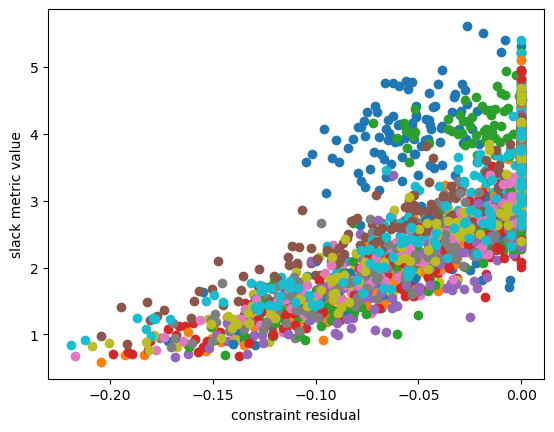

In [19]:
for k in range(n_dim):
    #plt.scatter(x_nm_test[:,k],pv[:,k])
    plt.scatter(-x_cvxpy_test.detach().numpy()[:,k],pv[:,k])
plt.xlabel('constraint residual')
plt.ylabel('slack metric value')

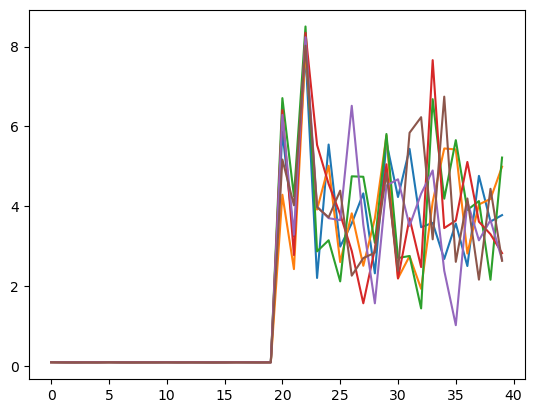

In [14]:


'''
Plot the meterics that are learned
'''


pr = samples_test['p']


j = 32
for j in [1,24,6,18,29,51]:
    a = solver.Pm_2('',pr[j,:])
    plt.plot(np.diag(a.detach().numpy()))


Text(0, 0.5, 'number of problems')

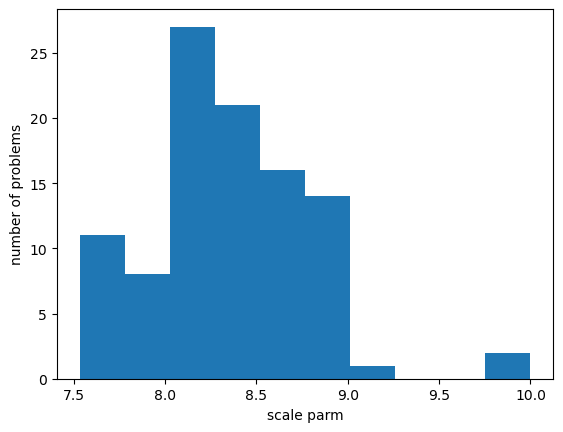

In [15]:

'''
Plot the scaling that is learned.
'''

td = next(iter(train_loader))
scl = torch.sigmoid(solver.Pm_2.ScaleMap(td['p']))
scl = scl_lb_P + scl*(scl_ub_P - scl_lb_P)
plt.hist(scl.detach().numpy())
plt.xlabel('scale parm')
plt.ylabel('number of problems')

In [5]:
'''
Convergence Evaluation
'''
solver.num_steps = 30

test_p = torch.tensor([ 0.0786, -0.1396,  0.0544,  0.5873, -0.1937,  0.0593,  0.2089, -0.2672,
         0.2413,  0.1833, -0.1695,  0.1558,  0.3340,  0.2615, -0.0777, -0.2420,
        -0.4748, -0.0198,  0.0820, -0.1486],dtype = torch.float32)

test_x = torch.tensor([0.0571, 0.0828, 0.1068, 0.0153, 0.0139, 0.0655, 0.0151, 0.0279, 0.0574,
        0.0053, 0.0264, 0.0175, 0.0355, 0.0876, 0.0247, 0.0498, 0.0314, 0.0840,
        0.0746, 0.1085],dtype = torch.float32)


#test_p = torch.tensor([p1,p2],dtype=torch.float32)
#test_x = torch.tensor([0.32,-0.37],dtype=torch.float32)
cvxpy_layer = cvx_qp(n_dim,Q,1)
x_cvxpy_test = cvxpy_layer(test_p)




test_x = torch.unsqueeze(test_x,0)
test_p = torch.unsqueeze(test_p,0)

x_hist = solver(test_x,test_p)[2]
x_hist = torch.stack(x_hist).detach().numpy()
x_hist = x_hist[:,0,0:20]

#np.save('Convergence_Data/portfolio20_DR.npy',x_hist)